In [1]:
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np

import abtem

# Multislice simulations

The multislice algorithm works by propagating the $xy$ part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive $z$ direction). A forward step through a slice of the potential consists of a transmission and a propagation. In the weak-phase approximation the transmission through a slice is just a phase shift proportional to the magnitude of the potential within that. To complete the multislice step, the transmitted wave is propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

## Multislice simulations with plane waves

Below we create a `Potential` and a `PlaneWave`:

In [2]:
atoms = read('data/srtio3_110.cif')

potential = abtem.Potential(atoms, slice_thickness=1)

wave = abtem.PlaneWave(energy=300e3, sampling=.05)

We create a task graph for running a simulation with the multislice algorithm with the `.multislice` method.

In [3]:
pw_exit_wave = wave.multislice(potential)

To execute the task graph, we call `.compute`.

In [4]:
pw_exit_wave.compute();

[########################################] | 100% Completed |  0.1s


````{note}

Notice that the sampling or extent was not provided above. When running a simulation of a wave function in conjuntion with a potential, the wave function will adopt the grid of the potential. On the other hand, the following results in an error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next code just results in a warning because the sampling of the wave function and the potential is different. The simulation task graph will be created using the grid of the potential.

```python
wave = PlaneWave(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```

````

## Intensity and diffraction patterns

We can now show the resulting exit wave. By default we show the intensity.

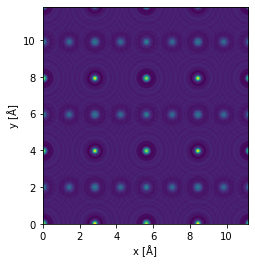

In [5]:
pw_exit_wave.show();

We can write the wave function to disk and load it again.

In [6]:
pw_exit_wave.to_zarr('data/srtio3_110_exit_wave.zarr', overwrite=True)

imported_wave = abtem.from_zarr('data/srtio3_110_exit_wave.zarr')

assert imported_wave == pw_exit_wave

The electron diffraction pattern can be obtained using the `.diffraction_patterns` method. We set `block_direct=True` since the direct beam often has much higher intensity than the scattered beams and thus we can't show it on the same scale.

In [17]:
pw_diffraction_pattern = pw_exit_wave.diffraction_patterns(block_direct=True, max_angle=11, parity='odd')

We show the diffraction pattern.

In [29]:
pw_diffraction_pattern.array.shape

(15, 15)

In [44]:
#plt.imshow(pw_diffraction_pattern.array)

kx, ky = pw_diffraction_pattern.angular_coordinates




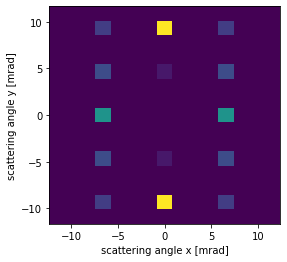

In [20]:
fig, ax = pw_diffraction_pattern.show(units='mrad')

It may be unexpected that the diffraction spot looks like squares, this is because the incoming beam is a periodic infinite plane wave, which means that the diffraction spots are single points. However, we are discretizing the wave function on a square grid (i.e. pixels), hence the spots can only be as small as single pixels.

## Real-space sampling

The real-space sampling is extremely important because it controls the accuracy of the simulation at high scattering angles. The sampling defines the maximum spatial frequency $k_{max}$ via the formula:

$$ k_{max} = \frac{1}{2p} \quad , $$

where $p$ is the real-space sampling distance. To counteract aliasing artifacts due to the periodicity assumption of a discrete Fourier transform, abTEM supresses spatial frequencies above 2 / 3 of the maximum scattering angle, further reducing the maximum effective scattering angle by a factor of 2 / 3. Hence the maximum scattering angle $\alpha_{max}$ is given by:

$$ \alpha_{max} = \frac{2}{3}\frac{\lambda}{2p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. As an example, consider a case where we want to simulate 80 keV electron scattering up to angles of 200 mrads. Plugging these values into the above equation gives a sampling of $\sim0.052$ Å, i.e. we require at least 0.05 Å pixel size in order to reach a maximum scattering angle of 200 mrads. In practice, you should ensure that the simulation is converged with respect to pixel size.

The maximum scattering angles in the $x$- and $y$-direction of the wave functions object can obtained

print(f'Maximal simulated scattering angles = {waves.cutoff_angles[0]:.3f} mrad')

## Multislice simulation with probe
For a probe, we need to provide the convergence semiangle (in mrad) via `semiangle_cutoff`.

In [24]:
probe = abtem.Probe(energy=200e3, semiangle_cutoff=30)

We want to position the probe on an atom hence we obtain the `xy` position of one of the atoms.

In [34]:
position = atoms.positions[0][:2]

positions = np.tile(position[None], (5, 1))
positions[:,0] += np.linspace(-.5, .5, 5)

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [35]:
probe_exit_wave = probe.multislice(scan=positions, potential=potential)

probe_exit_wave.compute()

[########################################] | 100% Completed |  0.3s


The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

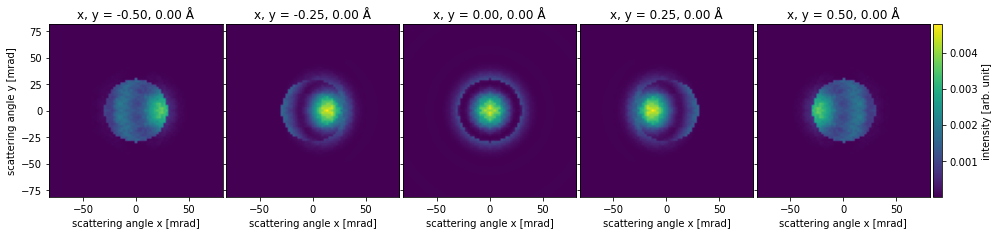

In [36]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns(max_angle=80)

ax, im = cbed_diffraction_pattern.show(units='mrad', explode=True, figsize=(16,6), common_color_scale=True, cbar=True, image_grid_kwargs = {'axes_pad': .05})

## Thickness series
CBED is often used for determining sample the thickness by comparing an experiment to a thickness series. 


In [98]:
potential = abtem.Potential(atoms, slice_thickness=1, exit_planes=2)

wave = abtem.PlaneWave(energy=300e3, sampling=.05)

In [99]:
exit_waves = wave.multislice(potential)

exit_waves.compute()

[########################################] | 100% Completed |  0.2s


In [100]:
diffraction_patterns = exit_waves[::3].diffraction_patterns(max_angle=30).block_direct()

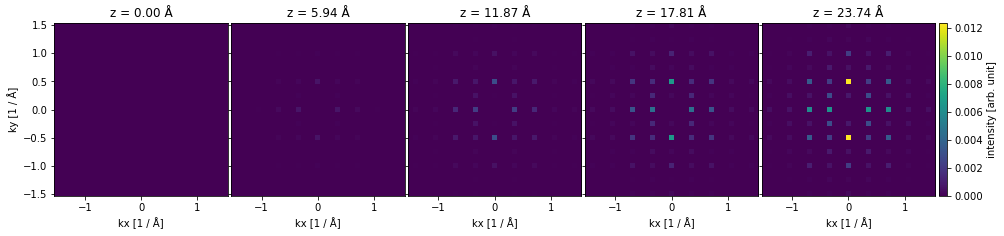

In [102]:
diffraction_patterns.show(explode = True, 
                          figsize = (16, 6),
                          common_color_scale = True,
                          cbar = True,
                          image_grid_kwargs = {'axes_pad': .05},
                          );